Import libraries

In [24]:
import seaborn as sn
import pandas as pd
import json, os
import numpy as np
import csv
import matplotlib.pyplot as plt
import random
from collections import OrderedDict
import time
import random

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, GlobalMaxPool1D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

from transformers import GPT2Tokenizer, TFAutoModelForSequenceClassification

from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, \
roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle


Specify a constant seeder for processes

In [2]:
seed = 123
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

Pre-trained tokenizer

In [3]:
model_variation = "microsoft/CodeGPT-small-py-adaptedGPT2"
PAD_TOKEN = "<|pad|>"
EOS_TOKEN = "<|endoftext|>"
tokenizer = GPT2Tokenizer.from_pretrained(model_variation, do_lower_case=True, pad_token=PAD_TOKEN,
    eos_token=EOS_TOKEN)

# gpt2 only NL
# microsoft/CodeGPT-small-py only PL
# microsoft/CodeGPT-small-py-adaptedGPT2 both NL and PL
# microsoft/CodeGPT-small-java
# microsoft/CodeGPT-small-java-adaptedGPT2

In [4]:
# Define New tokens for string and numerical i.e., strId$ and numId$
new_tokens = ["strId$", "numId$"]
for new_token in new_tokens:
    if new_token not in tokenizer.get_vocab().keys():
        tokenizer.add_tokens(new_token)

In [5]:
def recall_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = (true_positives + K.epsilon()) / (possible_positives + K.epsilon())
        return recall

def precision_metric(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = (true_positives + K.epsilon()) / (predicted_positives + K.epsilon())
        return precision

def f1_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f1 = 2*((prec*rec)/(prec+rec+K.epsilon()))
    return f1

def f2_metric(y_true, y_pred):

    prec = precision_metric(y_true, y_pred)
    rec = recall_metric(y_true, y_pred)
    f2 = 5*((prec*rec)/(4*prec+rec+K.epsilon()))
    return f2


Read dataset

In [ ]:
root_path = os.path.join('..', '..')
data = pd.read_csv(os.path.join(root_path, 'data', 'dataset.csv'))

Shuffle dataset

In [9]:
data = data.sample(frac=1, random_state=seed).reset_index(drop=True)
print(data.head())
print(len(data))

Explore data

Elements in dataset: 4184
2 categories found:
0
1


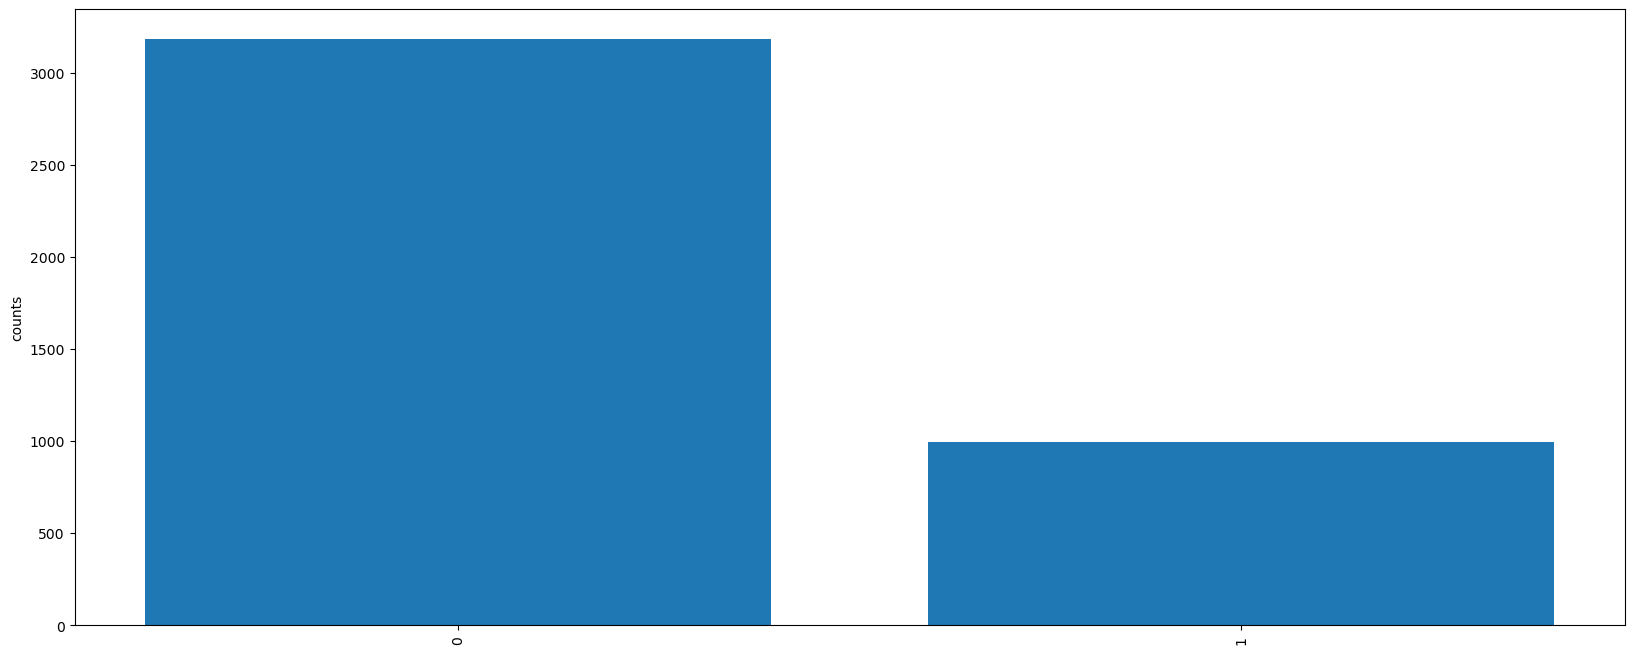

In [11]:
word_counts = data["func"].apply(lambda x: len(x.split()))
max_length = word_counts.max()
print("Maximum number of words:", max_length)

In [ ]:
vc = data["vul"].value_counts()

print(vc)

print("Percentage: ", (vc[1] / vc[0])*100, '%')

n_categories = len(vc)
print(n_categories)

In [12]:
data = pd.DataFrame(({'Text': data['func'], 'Labels': data['vul']}))
#data = data[0:100]
data.head()

Split to train-val-test

In [13]:
val_ratio = 0.10

In [14]:
shuffle_seeders = [seed, 10, 15, 20, 25, 30, 35, 40, 45, 50]
shuffle_seeder = shuffle_seeders[0]

train_val_data, test_data = train_test_split(data, test_size=val_ratio, random_state=shuffle_seeder, stratify=data['Labels'])
train_data, val_data = train_test_split(train_val_data, test_size=val_ratio, random_state=shuffle_seeder, stratify=train_val_data['Labels'])
# print(len(data))
# print(len(train_val_data))
# print(len(test_data))
# print(len(train_data))
# print(len(val_data))
# print(len(val_data)+len(train_data)+len(test_data))
# print(len(val_data)+len(train_data))

Pre-processing step: Under-sampling

In [ ]:
sampling = True
if n_categories == 2 and sampling == True:
    # Apply under-sampling with the specified strategy
    class_counts = pd.Series(train_data["Labels"]).value_counts()
    print("Class distribution ", class_counts)

    majority_class = class_counts.idxmax()
    print("Majority class ", majority_class)

    minority_class = class_counts.idxmin()
    print("Minority class ", minority_class)

    target_count = class_counts[class_counts.idxmin()] # int(class_counts.iloc[0] / 2) 
    print("Targeted number of majority class", target_count)

    # under
    sampling_strategy = {majority_class: target_count}        
    rus = RandomUnderSampler(random_state=seed, sampling_strategy=sampling_strategy)

    x_train_resampled, y_train_resampled = rus.fit_resample(np.array(train_data["Text"]).reshape(-1, 1), train_data["Labels"]) 
    print("Class distribution after augmentation", pd.Series(y_train_resampled).value_counts())


    # Shuffle the resampled data while preserving the correspondence between features and labels
    x_train_resampled, y_train_resampled = shuffle(x_train_resampled, y_train_resampled, random_state=seed)

    # rename
    X_train = x_train_resampled
    Y_train = y_train_resampled

    X_train = pd.Series(X_train.reshape(-1))

else:
    X_train = train_data["Text"]
    Y_train = train_data["Labels"]

Pre-trained model

In [15]:
model = TFAutoModelForSequenceClassification.from_pretrained(model_variation,
        pad_token_id=tokenizer.pad_token_id,
        eos_token_id=tokenizer.eos_token_id, num_labels=n_categories)

config = model.get_config()
print(config)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'return_dict': True, 'output_hidden_states': False, 'output_attentions': False, 'torchscript': False, 'torch_dtype': None, 'use_bfloat16': False, 'tf_legacy_loss': False, 'pruned_heads': {}, 'tie_word_embeddings': True, 'is_encoder_decoder': False, 'is_decoder': False, 'cross_attention_hidden_size': None, 'add_cross_attention': False, 'tie_encoder_decoder': False, 'max_length': 20, 'min_length': 0, 'do_sample': False, 'early_stopping': False, 'num_beams': 1, 'num_beam_groups': 1, 'diversity_penalty': 0.0, 'temperature': 1.0, 'top_k': 50, 'top_p': 1.0, 'typical_p': 1.0, 'repetition_penalty': 1.0, 'length_penalty': 1.0, 'no_repeat_ngram_size': 0, 'encoder_no_repeat_ngram_size': 0, 'bad_words_ids': None, 'num_return_sequences': 1, 'chunk_size_feed_forward': 0, 'output_scores': False, 'return_dict_in_generate': False, 'forced_bos_token_id': None, 'forced_eos_token_id': None, 'remove_invalid_values': False, 'exponential_decay_length_penalty': None, 'suppress_tokens': None, 'begin_suppress_

Resize model embedding to match new tokenizer

In [16]:
model.resize_token_embeddings(len(tokenizer))

Decide which pre-trained layers to freeze

In [ ]:
for layer in model.layers:
    layer.trainable = True

Print model summary

In [ ]:
model.summary()

Compute maximum length

In [17]:
def getMaxLen(X):

    # Code for identifying max length of the data samples after tokenization using transformer tokenizer
    
    max_length = 0
    # Iterate over each sample in your dataset
    for i, input_ids in enumerate(X['input_ids']):
        # Calculate the length of the tokenized sequence for the current sample
        length = tf.math.reduce_sum(tf.cast(input_ids != 1, tf.int32)).numpy()
        # Update max_length and max_row if the current length is greater
        if length > max_length:
            max_length = length
            max_row = i

    print("Max length of tokenized data:", max_length)
    print("Row with max length:", max_row)

    #X['input_ids'] = np.delete(X['input_ids'], max_row, axis=0)
    
    return max_length

In [18]:
X = tokenizer(
        text=X_train.tolist(),
        add_special_tokens=True,
        max_length=512,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=False,
        return_attention_mask=True,
        verbose=True
    )

max_len = getMaxLen(X)

Max length of tokenized data: 512
Row with max length: 4


Tokenization

In [19]:
X_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_val = tokenizer(
    text=val_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

X_test = tokenizer(
    text=test_data['Text'].tolist(),
    add_special_tokens=True,
    max_length=max_len,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

Hyper-parameters

In [20]:
n_epochs = 6
batch_size = 6
lr = 2e-05 # 1e-5
patience = 5

In [21]:
optimizer = Adam(
    learning_rate=lr, # HF recommendation
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0
)

loss = CategoricalCrossentropy(from_logits=True)

Build Model

In [22]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=[f1_metric]
)

Train model

In [ ]:
print("Training...")
milli_sec1 = int(round(time.time() * 1000))

early_stopping = EarlyStopping(monitor='val_f1_metric', mode='max', patience=patience)
model_checkpoint = ModelCheckpoint('./checkpoints/best_weights', monitor='val_f1_metric', mode='max', save_best_only=True)

history = model.fit(
    x = {'input_ids':X_train['input_ids'], 'attention_mask':X_train['attention_mask']},
    y = to_categorical(Y_train),
    validation_data = ({'input_ids':X_val['input_ids'], 'attention_mask':X_val['attention_mask']},
                        to_categorical(val_data['Labels'])),
    epochs=n_epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, model_checkpoint]
)

milli_sec2 = int(round(time.time() * 1000))
print("Training is completed after", milli_sec2-milli_sec1)

Training...
Epoch 1/6
454/565 [=======================>......] - ETA: 58s - loss: 0.3758 - f1_metric: 0.7994

In [ ]:
plt.plot(history.history['f1_metric'])
plt.plot(history.history['val_f1_metric'])
plt.ylabel('model f1_metric')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
#plt.savefig('train_history.png')
plt.show()


Load best model from checkpoint during training with early stopping

In [ ]:
model.load_weights('./checkpoints/best_weights')

Classification report on validation data

In [ ]:
print(classification_report(val_data['Labels'], np.argmax(model.predict({'input_ids': X_val['input_ids'], 'attention_mask': X_val['attention_mask']}).logits, axis=1)))

Make predictions on the testing set and compute evaluation metrics

In [ ]:
predicted = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']}).logits
y_predicted = np.argmax(predicted, axis=1)

targets = test_data['Labels']
print(classification_report(targets, y_predicted))

In [ ]:
accuracy=accuracy_score(targets, y_predicted)
precision=precision_score(targets, y_predicted)
recall=recall_score(targets, y_predicted)
roc_auc=roc_auc_score(targets, y_predicted)
f1=f1_score(targets, y_predicted)
f2 = (5*precision*recall) / (4*precision+recall)

conf_matrix = confusion_matrix(targets, y_predicted)
sn.heatmap(conf_matrix, annot=True)

tn, fp, fn, tp = conf_matrix.ravel()
acc = ((tp+tn)/(tp+tn+fp+fn))
print("TP=",tp)
print("TN=",tn)
print("FP=",fp)
print("FN=",fn)

print("Accuracy:%.2f%%"%(accuracy*100))
print("Precision:%.2f%%"%(precision*100))
print("Recall:%.2f%%"%(recall*100))
print("Roc_Auc score:%.2f%%"%(roc_auc*100))
print("F1 score:%.2f%%"%(f1*100))
print("F2 score:%.2f%%"%(f2*100))

Export classification report

In [ ]:
method = "forSequence"

In [ ]:
# Create the path
path = os.path.join(root_path, 'results', model_variation.split("/")[-1], method, str(shuffle_seeder))

# Create directory if it doesn't exist
os.makedirs(path, exist_ok=True)

# Define the CSV file path
csv_file_path = os.path.join(path, f"{shuffle_seeder}.csv")

# Write data to CSV
data = {
    "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
    "f1": f1,
    "f2": f2,
    "roc_auc": roc_auc
}

# Write to CSV
with open(csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=data.keys())
    writer.writeheader()
    writer.writerow(data)


Compute the average values of the classication metrics considering the results for all different seeders

In [ ]:
# Define a dictionary to store cumulative sum of metrics
cumulative_metrics = defaultdict(float)
count = 0  # Counter to keep track of number of CSV files

# Iterate over all CSV files in the results folder
results_folder = os.path.join(root_path, "results", model_variation.split("/")[-1], method, str(shuffle_seeder))
for filename in os.listdir(results_folder):
    if filename.endswith(".csv"):
        csv_file_path = os.path.join(results_folder, filename)
        with open(csv_file_path, "r", newline="") as csvfile:
            reader = csv.DictReader(csvfile)
            for row in reader:
                for metric, value in row.items():
                    cumulative_metrics[metric] += float(value)
        count += 1
        
# Compute average values
average_metrics = {metric: total / count for metric, total in cumulative_metrics.items()}

# Print average values 
print(average_metrics)

# Define the path for the average CSV file
avg_csv_file_path = os.path.join(root_path, "results", model_variation.split("/")[-1], method, "avg.csv")

# Write average metrics to CSV
with open(avg_csv_file_path, "w", newline="") as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=average_metrics.keys())
    writer.writeheader()
    writer.writerow(average_metrics)